## Wild Blueberry Yield Prediction Challenge
 In this Kaggle competition, we worked
with the Wild Blueberry Yield Prediction Dataset to explore the relationships between multiple variables
and predict yield using multiple linear regression. We implemented regression from scratch. We explored multi-variate OLS and kernel regression techniques and used the code implemented in previous questions. Then we selected an approach that gives us the least error (MAE) and fitted our model to predict yield on test data.

### Load the data

In [250]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv('../train.csv', index_col='id', sep=',')
df_test = pd.read_csv('../test.csv', index_col='id', sep=',')

df_new=df

### Plot the features to see their distribution

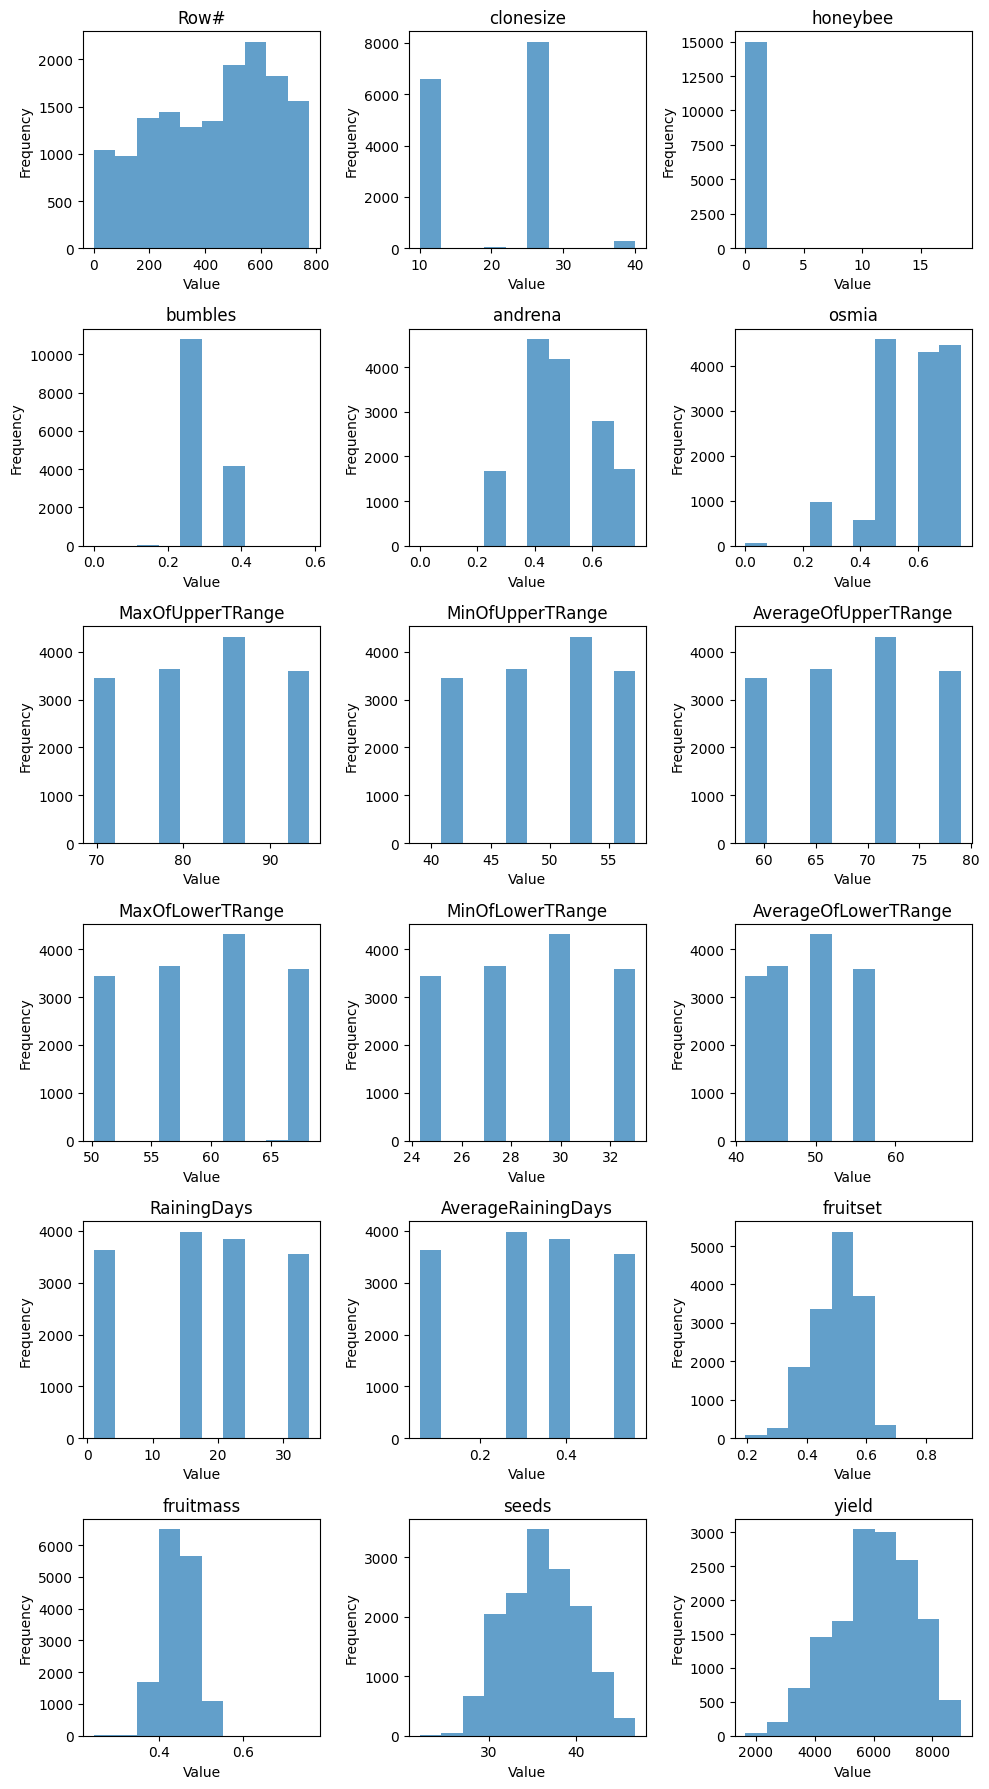

In [251]:
# Set the number of rows and columns for subplots
num_features = len(df.columns)
num_cols = 3  # Number of columns for subplots
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each feature and plot
for i, column in enumerate(df.columns):
    axes[i].hist(df[column], bins=10, alpha=0.7)
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### Analyzing features with heavy correlation among themselves
Looking at the above plot, we find that features with temparature range (Max, Min, Average etc.) and raining days have very similar plots. These features may have high correaltion among themselves. To find out correlation, we use pairplots and Pearson correlation coefficient.

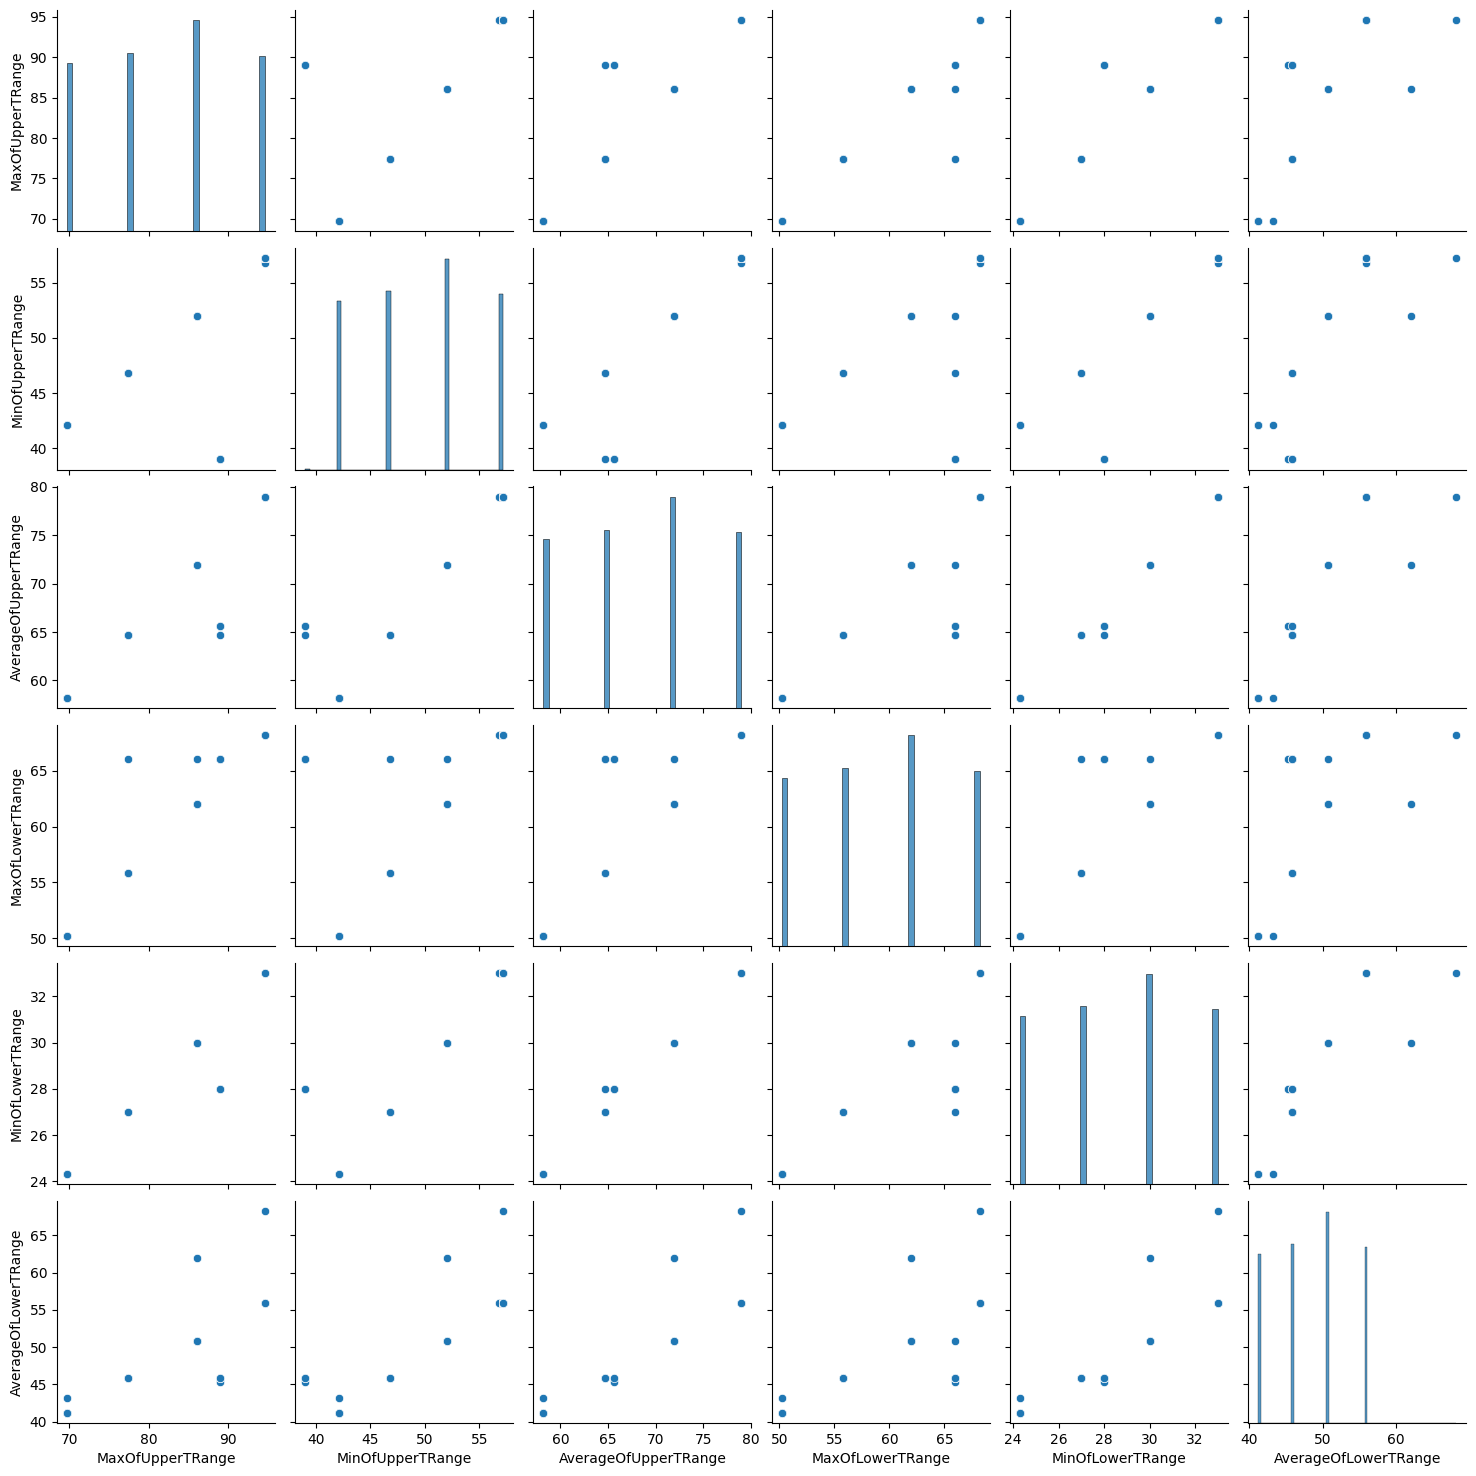

In [252]:
selected_features = ['MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange','MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange']

# Create pairplot for the selected features
sns.pairplot(df[selected_features])
plt.show()

In [253]:
corr = df[['MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange']].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

corr = df[['MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange']].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

corr = df[['MaxOfLowerTRange','MaxOfUpperTRange', 'AverageOfLowerTRange', 'AverageOfUpperTRange']].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

Pearson correlation coefficient matrix of each variables:
                       MaxOfUpperTRange  MinOfUpperTRange  AverageOfUpperTRange
MaxOfUpperTRange              1.000000          0.999274              0.999844
MinOfUpperTRange              0.999274          1.000000              0.999770
AverageOfUpperTRange          0.999844          0.999770              1.000000
Pearson correlation coefficient matrix of each variables:
                       MaxOfLowerTRange  MinOfLowerTRange  AverageOfLowerTRange
MaxOfLowerTRange              1.000000          0.999753              0.999323
MinOfLowerTRange              0.999753          1.000000              0.999653
AverageOfLowerTRange          0.999323          0.999653              1.000000
Pearson correlation coefficient matrix of each variables:
                       MaxOfLowerTRange  MaxOfUpperTRange  \
MaxOfLowerTRange              1.000000          0.999897   
MaxOfUpperTRange              0.999897          1.000000   
AverageOfLo

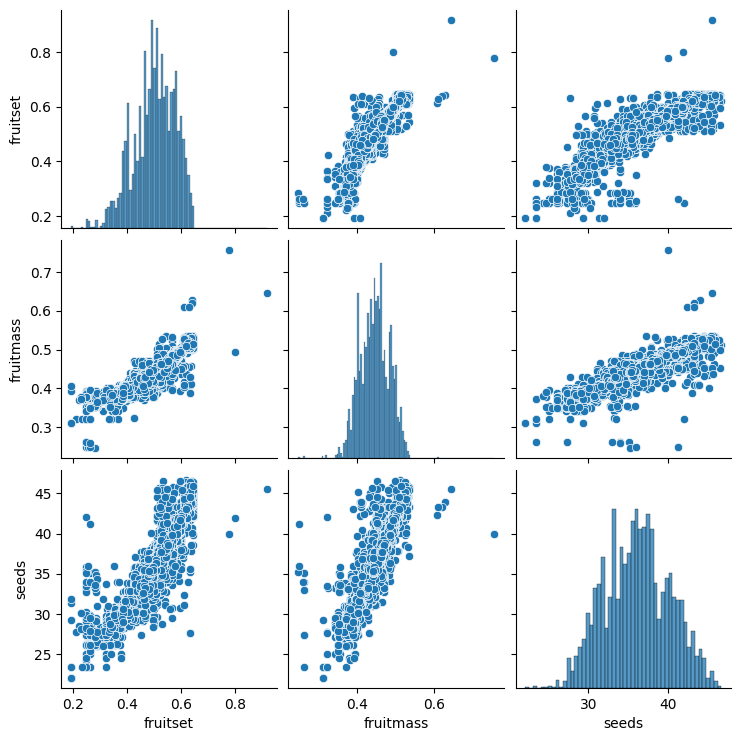

Pearson correlation coefficient matrix of each variables:
            fruitset  fruitmass     seeds
fruitset   1.000000   0.937357  0.947179
fruitmass  0.937357   1.000000  0.941995
seeds      0.947179   0.941995  1.000000


In [254]:
selected_features = ['fruitset', 'fruitmass', 'seeds']

# Create pairplot for the selected features
sns.pairplot(df[selected_features])
plt.show()

corr = df[selected_features].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

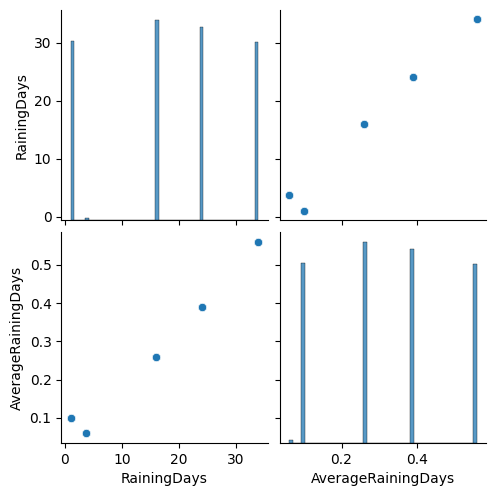

Pearson correlation coefficient matrix of each variables:
                     RainingDays  AverageRainingDays
RainingDays            1.000000            0.991722
AverageRainingDays     0.991722            1.000000


In [255]:
selected_features = ['RainingDays', 'AverageRainingDays']

# Create pairplot for the selected features
sns.pairplot(df[selected_features])
plt.show()

corr = df[selected_features].corr()
print('Pearson correlation coefficient matrix of each variables:\n', corr)

High correlation between these features implies they may be dependent on each other. They may be dropped because they don't give any new information on the yield data

### Define functions used for regression
Now we define our kernel regression functions, multiple linear regression, and corresponding error(MAE) functions. We shuffle and split the data using k-fold cross validation method. Then we train the model and minimize error by cross-validation.

1. Multi-feature Kernel regression

In [256]:
# Different Kernel functions

def gaussian_kernel(x1, x2, h):
    normalized_difference = (x1 - x2).astype(float) / h
    return np.exp(- (normalized_difference ** 2)/2) / np.sqrt(2 * np.pi)

def uniform_kernel(x1, x2, h):
    normalized_difference = (x1 - x2).astype(float) / h
    return (np.abs(normalized_difference)<1).astype(float)/2

def epanechnikov_kernel(x1, x2, h):
    normalized_difference = (x1 - x2).astype(float) / h
    return np.maximum(1-normalized_difference**2,0)*0.75


def shuffle_and_split(df, k):
    """
    Shuffle a DataFrame and split it into k datasets
    Returns:
        A list containing k DataFrames
    """
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=1, random_state=4).reset_index(drop=True)
    
    # Split the DataFrame into k datasets
    split_dfs = np.array_split(shuffled_df, k)
    
    return split_dfs

def kernel_regression_multifeature(train_data, x, p, kernel, h):
    """
    Evaluate the value of estimated kernel regression function at a point x=(x1,x2,...xk) based on the training data ,
    specified kernel function ,bandwidth h and parameter p used to calculate distance between 2 points as 
    distance = (sum(xi_1-xi_2)**p)^1/p
    """
    # Calculating Lp-norm distances
    dist = (np.transpose(train_data[:, :-1]) - x[:,None])
    dist_p = np.power(np.sum(dist**p, axis=0),float(1)/p) 

    k_x_xi=kernel(dist_p,0,h)
    sum1=np.sum(k_x_xi)

    k_x_xi_y=k_x_xi*train_data[:,-1]
    sum2=np.sum(k_x_xi_y)
    
    if(sum1==0): return 0
    return sum2/sum1

def calc_error_kernel(train_data, cv_data, kernel, h):
    """
    Evaluate the absolute error of kernel density function estimated using the training data on cv_data 
    """
    mae=0
    square_error=0

    for i in range(cv_data.shape[0]):
        est = kernel_regression_multifeature(train_data, cv_data[i][:-1], 2, kernel, h)
        mae+=np.abs(est-cv_data[i][-1])
        square_error+=(est-cv_data[i][-1])**2
    return mae

def calc_mae_kernel(data, kernel, h, k):
    """
    Evaluate the risk of kernel regression estimation using k-fold cross validation 
    Input :
    data - complete data
    kernel - gaussian/uniform/epanechnikov kernel
    h - bandwidth
    k - for k-fold cross validation
    """
    split_data=shuffle_and_split(data, k)
    total_error=0

    for i in range(k):
        # Concatenate test DataFrames into a single DataFrame
        combined_df = pd.concat([df for j, df in enumerate(split_data) if j != i] , ignore_index=True)

        # Convert the combined DataFrame to a NumPy array
        train_data = combined_df.to_numpy()
        test_data = split_data[i].to_numpy()
        
        total_error+=calc_error_kernel(train_data, test_data, kernel, h)

    return total_error/data.shape[0]

2. Multi-variate Least Square regression 

In [282]:

def train_multiple_regression(train_data):
    # Returns least square estimator of the weights of each feature
    Y=train_data[:,-1] 
    X=train_data[:,:-1]
    X=np.concatenate((np.ones_like(Y)[:, np.newaxis], X), axis=1) # add a column  of ones

    # Least square estimate is obtained by 
    # B=(X'X)^-1.(X'Y)  (X' is X.Transpose())
    XtX=np.matmul(X.transpose(),X)
    XtY=np.matmul(X.transpose(),Y)
    B=np.matmul(np.linalg.inv(np.float64(XtX)),XtY)
    return B

def predict_multiple_regression(train_data, test_data):
    # Train and predict on Test data
    B=train_multiple_regression(train_data)
    X_test=np.concatenate((np.ones(test_data.shape[0])[:, np.newaxis], test_data), axis=1)
    return np.matmul(X_test, B)

def calc_mae_regr(data, k, std=False):
    """
    Evaluate the risk of multi-linear least square regression estimation using k-fold cross validation 
    Input :
    data - complete data
    k - for k-fold cross validation
    """
    split_data=shuffle_and_split(data, k)
    total_error=0

    for i in range(k):
        # Concatenate test DataFrames into a single DataFrame
        combined_df = pd.concat([df for j, df in enumerate(split_data) if j != i] , ignore_index=True)

        # Removing outliers 
        if not std:
            combined_df=combined_df[combined_df['yield']>=3000]
            combined_df=combined_df[combined_df['yield']<=8500]

        # Convert the combined DataFrame to a NumPy array
        train_data = combined_df.to_numpy()
        test_data = split_data[i].to_numpy()

        total_error+=calc_error_regr(train_data, test_data)

    return total_error/data.shape[0]

def calc_error_regr(train_data, cv_data):
    """
    Evaluate the absolute error of least square estimated using the training data on cv_data 
    """
    mae=0
    pred1 = predict_multiple_regression(train_data, cv_data[:,:-1])
    mae=np.sum(np.abs(pred1-cv_data[:,-1]))

    return mae


3. Mixed Kernel and Linear regression models

In [283]:

def calc_mae_mixed(data, k, kernel, h):

    """
    Evaluate the risk of kernel regression estimation using k-fold cross validation 
    Input :
    data - complete data
    kernel - gaussian/uniform/epanechnikov kernel
    h - bandwidth
    k - for k-fold cross validation
    """

    split_data=shuffle_and_split(data, k)
    total_error=0

    for i in range(k):
        # Concatenate test DataFrames into a single DataFrame
        combined_df = pd.concat([df for j, df in enumerate(split_data) if j != i] , ignore_index=True)

        # Convert the combined DataFrame to a NumPy array
        train_data = combined_df.to_numpy()
        test_data = split_data[i].to_numpy()
        
        total_error+=calc_error_mixed(train_data, test_data, kernel, h)

    return total_error/data.shape[0]

def calc_error_mixed(train_data, cv_data, kernel, h):
    """
    Evaluate the square error of kernel density function estimated using the training data on cv_data 
    """
    mae=0

    pred1 = predict_multiple_regression(train_data, cv_data[:,:-1])
    pred2 = [kernel_regression_multifeature(train_data, cv_data[i][:-1], 2, kernel, h) for i in range(cv_data.shape[0])]
    pred2 = np.array(pred2)

    # Weights for multiple and kernel regression
    est= 0.95*pred1 + 0.05*pred2
    mae=np.sum(np.abs(est-cv_data[:,-1]))

    return mae

Predict functions

In [284]:

def predict(kernel, h):

    with open("../sample_submission.csv", 'w') as f:
        f.write("id,yield\n")
        for i in range(10000):
            est = kernel_regression_multifeature(df.to_numpy(), df_test.to_numpy()[i][:], 2, kernel, h)
            j = i+15000
            f.write("{},{}\n".format(j,est))

def predict_regr():

    with open("../sample_submission.csv", 'w') as f:
        f.write("id,yield\n")
        required_features1= ['honeybee', 'seeds', 'RainingDays', 'clonesize', 'Row#', 'yield']
        required_features2= ['honeybee', 'seeds', 'RainingDays', 'clonesize', 'Row#']
        df1=df
        df2=df_test
        est = predict_multiple_regression(df1.to_numpy(), df2.to_numpy())
        for i in range(10000):
            j = i+15000
            f.write("{},{}\n".format(j,est[i]))

def predict(train_data, test_data, kernel, h, strategy,submit = False):

    with open("../sample_submission.csv", 'w') as f:
        f.write("id,yield\n")
        if(strategy==1):
            pred = predict_multiple_regression(df.to_numpy(), df_test.to_numpy())
        elif(strategy==2):
            for i in range(test_data.shape[0]):
                pred = kernel_regression_multifeature(train_data, test_data[i], 2, kernel, h)
        elif(strategy==3):
            pred1 = predict_multiple_regression(df.to_numpy(), df_test.to_numpy())
            for i in range(test_data.shape[0]):
                pred2 = kernel_regression_multifeature(train_data, test_data[i], 2, kernel, h)
            pred= 0.6*pred1 + 0.4*pred2
        else:
            pass
        if(submit):
            for i in range(pred.shape()[0]):
                j = i+15000
                f.write("{},{}\n".format(j,pred[i]))

def calc_mae(y_pred, y):
    return np.average(np.abs(y_pred-y))

### Comparing performance of different models
#### 1.Kernel regression

In [285]:
# Varying h (bandwidth)
print("error=", calc_mae_kernel(df, gaussian_kernel, 1.8, 3))

# error= 541.0241462185593 (best from kernel)

KeyboardInterrupt: 

#### 2.Multi-Linear Regression

In [287]:
print("error=",calc_mae_regr(df, 5))

# error= 270.2285534507598

error= 270.46470999147493


#### 3.Mixed model

In [ ]:
# print("error=", calc_error_mixed(df, ))

#### 3. After standardization 

In [286]:
# Scaling all features to same scale so that trained model is not biased towards higher value features
yield_factor=df['yield'].std()
df_std=(df-df.mean())/df.std()

print("error=", calc_mae_regr(df_std, 5, std=True)*yield_factor)
# error= 270.22856283585713 
# Normalization have no effect in linear regression model

error= 270.22856283585713


In [291]:
# Removing outliers from data
df_new=df[df['yield']>=3000]
df_new=df_new[df_new['yield']<=8500]

print("error=", calc_mae_regr(df_new, 5))
# error= 253.7285651362452

# Generate prediction
# predict_regr()


error= 253.7285651362452
